## Cats vs Dogs CV

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

test
train



In [2]:
# Necessary imports
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

# What will explain these imports when we build the model.
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

Using TensorFlow backend.


## Preparing the Data

This function resizes the images to 64x64 and samples 2000 images (8%) of the data to run efficiently as a Kaggle Kernel.  

In [3]:
TRAIN_DIR = '../input/train/'
TEST_DIR = '../input/test/'

ROWS = 64
COLS = 64

# What are channels?  This is because we are reading the values in as RGB so 3 values/ pixel
CHANNELS = 3

# We have to do this because each image is in its own file
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# Only get 1000 of each
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images = test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    
    # What is interpolation? This specifies that when we resize we zoom out
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

# We store all of the data in an array of length count
def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        
    return data

train = prep_data(train_images)

test = prep_data(test_images)
print(train.shape)

(2000, 3, 64, 64)


## Checking out Images

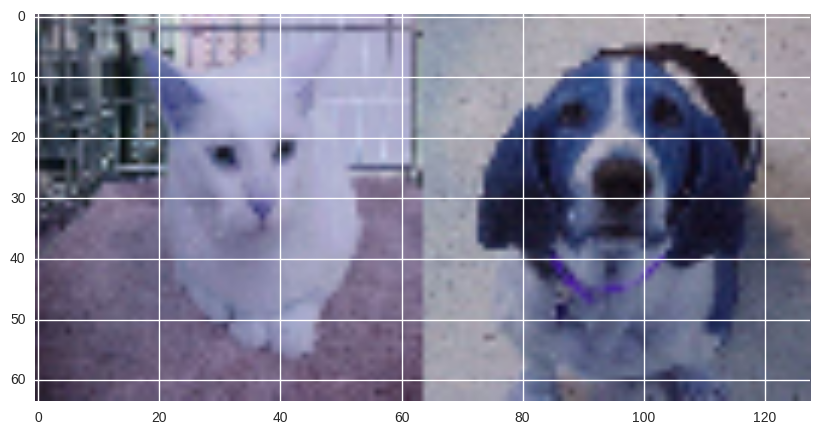

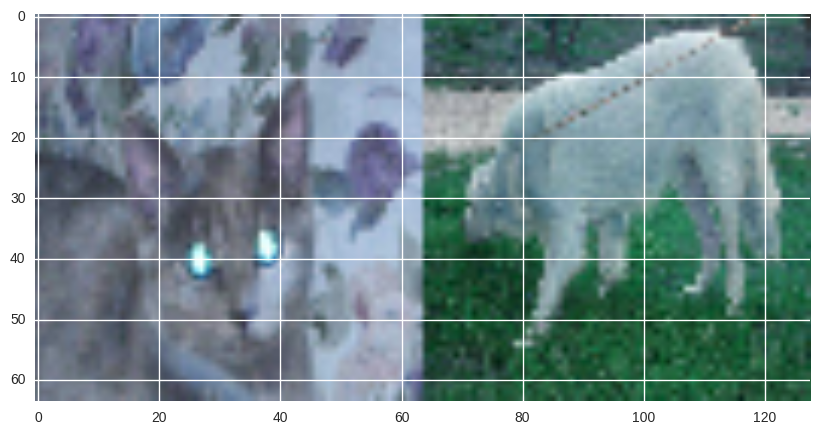

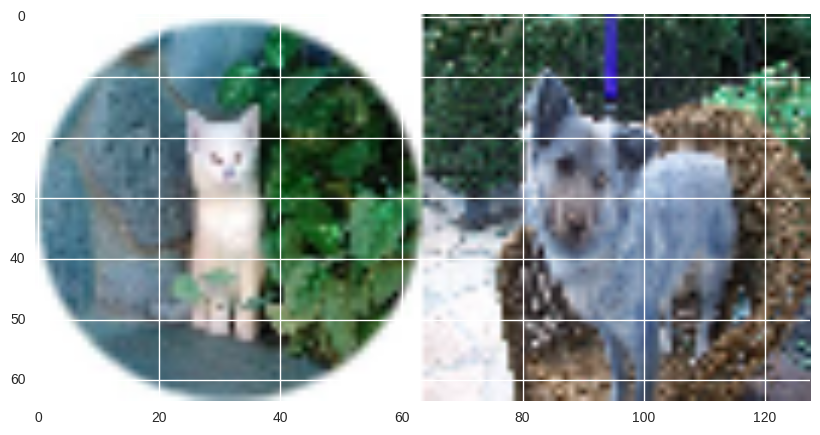

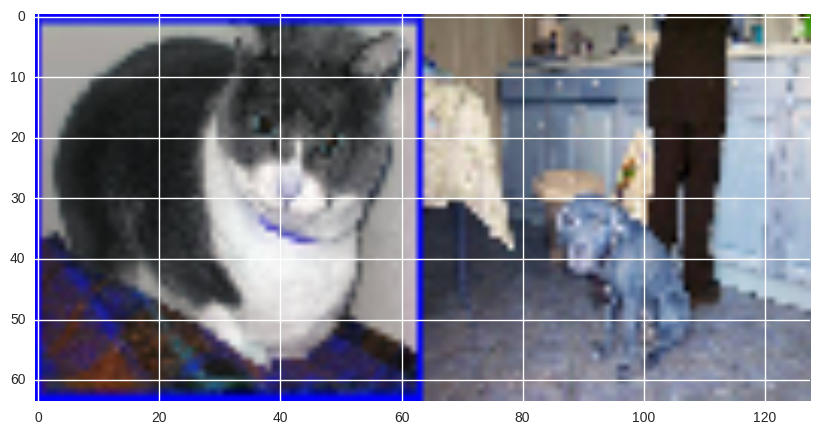

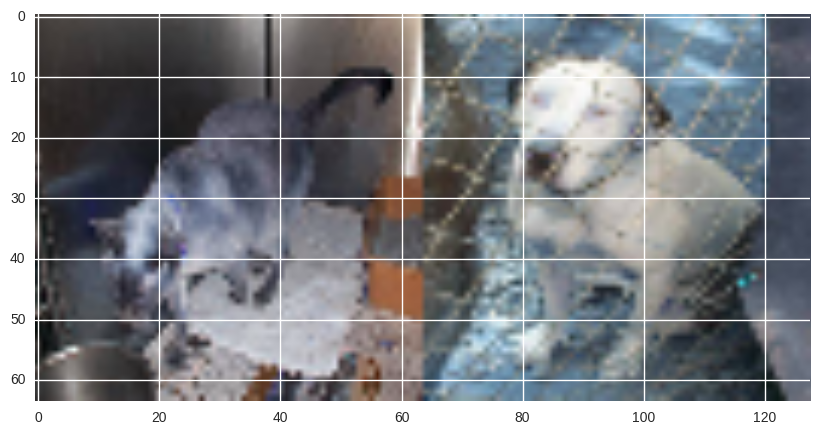

In [4]:
# The read_image method will open the file name, read in the numerical data for the pixels
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,15))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

## Average Cat and Dog ##

In [5]:
# How do we generate an average cat and dog picture?
avg_cat = []

(64, 64)


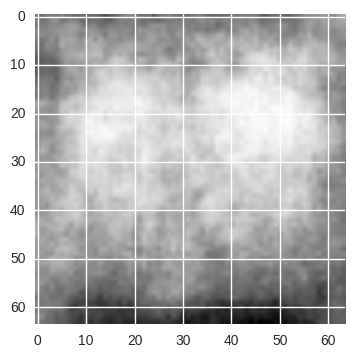

In [6]:
# We will iterate through train and check if it is a dog and sum over that way
# Train has already been processed through read_image which reads in using
# cv.imread()

# We want to be able to iterate through and figure out which is a cat and which is 
# a dog so let's create an array of labels

labels = []
for img in train_images:
    if 'dog' in img:
        labels.append(1)
    else:
        labels.append(0)

# We storing 3 channels and thus need to get dog[0], this is the first channel

dog_avg = np.array([dog[0].T for i, dog in enumerate(train) 
                    if labels[i] == 1]).mean(axis=0)
print(dog_avg.shape)
# Now I want to display my avg_dog
plt.imshow(dog_avg)
plt.show()


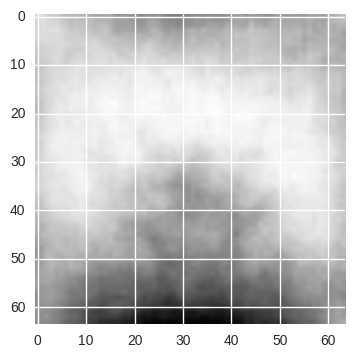

In [7]:
# Now let me create an average cat
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) 
                    if labels[i] == 0]).mean(axis=0)
plt.imshow(cat_avg)
plt.show()

## CatdogNet-16

**Some notes about Keras models:**

 - Keras is a framework for neural networks with pre-built layers
 - Layers include: Regular dense, Recurrent, Noise layers (Gaussian)
 - Each layer has its own activation function
 - Build a neural network with: 
       - add() - adds layers from left to right to your model
       - compile() - provides info regarding the loss function and 
       - fit(train, batch, epochs, accuracy) - creates the neural network
       - predict() - get predictions

**Terms**

 What is a sequential model? 
 - A linear stack of layers

What is a callback?
- Saves the weights your model has currently

What is an epoch?
- A full pass over all your training data

What is EarlyStopping?
- Stops training model when a specified value has stopped improving

Optimizer - RMSprop(1r=1e-4)
- RMSprop is an optimization of back- propagation to learn the weights of a neural network

Objective - 'binary_crossentropy'
- this is the loss function of our problem: mean-squared error, mean-absolute error
- binary_crossentropy is the same as log_loss
- log_loss is used when you have binary outputs 0, 1 but your predictions from the network are probabilities (0,1).  Thus you don't want to just say > 0.5 = 1 and <0.5 = 0.  Instead you weight the probabilities accordingly.  

logLoss=logLoss=−1N−1N∑Ni=1∑i=1N(yi(logpi)+(1−yi)log(1−pi))

 - Through this formula we essentially smoothen the hinge classification method

In [8]:
optimizer = RMSprop (lr=1e-4)
objective = 'binary_crossentropy'

def catdog():
    # How did you come up with this layer technique?
    model = Sequential()
    
    model.add(Convolution2D(32, 3, 3, border_mode='same', 
                            input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', 
                           activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), dim_ordering="th"))
    
    model.add(Convolution2D(64, 3, 3, border_mode='same', 
                            input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', 
                           activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), dim_ordering="th"))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', 
                            input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', 
                           activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), dim_ordering="th"))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', 
                            input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', 
                           activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), dim_ordering="th"))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()

What's convolution doing?

 - First we have our image represented as a 64x64x3 - dimensions of image with 3 RGB per pixel
Convolution means that we pass a filter over the image.  We can pass a Guassian blur which will average the pixels with those around it.  
As a mathematical function, convolution follows the same properties as a linear time invariant system - additive, time invariant and the superposition principle.  Convolution serves to pass a mask over a pixel grid and convert those values into a single point representation.

What are the parameters for Convolution2D?
Convolution2D(no_filters, filter_rows, filter_cols, result_size)
Thus we can see in our ConvNet we have used a filter over various sized regions, small, medium and large.

What's MaxPooling2D?
This will downsize the data making it more manageable.  This decreases the size.

In [9]:
nb_epoch = 10
batch_size = 16

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
# EarlyStopping will terminate the training when 'val_loss' stops changing for 3 iterations
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

## Visualize the loss ##

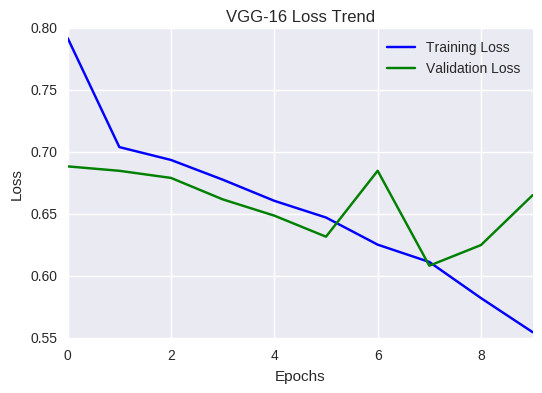

In [10]:
# How can we visualize how our model is decreasing the loss over iterations?
# We stored the loss values in LossHistory
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()